# Modele generatywne; Modele dyfuzji 

Ostatnią klasą modeli generatywnych, które poznamy są modele dyfuzji ([Sohl-Dickstein et al., 2015](https://arxiv.org/pdf/1503.03585), [Ho et al., 2020](https://arxiv.org/pdf/2006.11239), [Rombach et al., 2022](https://arxiv.org/pdf/2112.10752)). Inspiracją stojącą za tymi modelami jest znane z  termodynamiki stanów nierównowagowych, zjawisko dyfuzji - procesu samorzutnego przenikania się cząsteczek lub energii w każdym ośrodku o temperaturze $\tau > 0$ K, będący konsekwencją chaotycznych zderzeń cząsteczek dyfundującej substancji: 

[![](https://upload.wikimedia.org/wikipedia/commons/9/90/Diffusion_microscopic_picture.gif)]()
*źródło: Wikipedia*

W przypadku sieci neuronowych opartych na mechanizmie dyfuzji naszym celem będzie modelowanie procesu rozpadu danych do postaci rozkładu prawdopodobieństwa $\pi(x)$, otrzymananego za pomocą powtarzanego $T \to \infty$ razy zaszumiania danych:

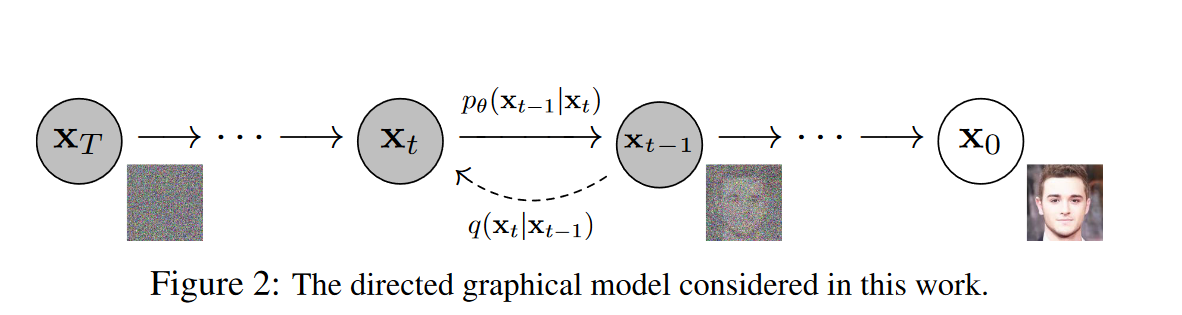
*źródło: [Ho et al., 2020](https://arxiv.org/pdf/2006.11239)*

Logika ich działania dosyć unkalna w porównaniu z innymi typami modeli generatywnych, uczą się one za pomocą jasno określonego procesu, który dodatkowo tworzy zmienne ukryte mające taką samą wymiarowość jak oryginalne dane.

Proces dyfuzji jest z definicji ciągłym procesem Markowa, szum nakładany na dane jest generowany za pomocą jądra dyfuzji $D_\pi(x|x^\prime, \beta)$, gdzie $\beta$ to stopa dyfuzji:
$$\pi(x) = \int D_\pi(x|x^\prime, \beta) \pi(x^\prime) dx^\prime $$
w szczególności:
$$q(x_t|x_{t-1}) = D_\pi(x_t|x_{t-1}, \beta_t)$$

Zazwyczaj przyjmujemy, że $\pi(x)$ jest łatwym do analitycznego rozwiązania rozkładem, stąd też najczęściej wykorzystywanym procesem generatywnym jest proces Gaussowski:
$$q(x_t|x_{t-1}) = \mathcal{N}(x_{t-1},\sqrt{1 - \beta_t}x_{t-1}, \beta_t \bf{I})$$

dodatkowo zakładamy, że sekwencja $\{\beta_t \in (0,1)\}_i^T$ jest ściśle rosnąca - im dalej jesteśmy w trakcie trwania tego procesu tym większy może być szum nakładany na dane.

Dzięki temu jesteśmy w stanie przedstawić zachodzący proces dyfuzji w dość prosty sposób:
$$q(x_T) = q(x_0)\prod_{t=1}^Tq(x_t|x_{t-1})$$

Proces odwrotnej dyfuzji zachowuje się podobnie:

$$p(x_0) = \int p(x_{(0,1,\dots,T)})dx_{(0,1,\dots,T)}$$

czy też:

$$p(x_0) = p(x_T)\prod_{t=1}^T p(x_{t-1}|x_t)$$,

gdzie $x_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. 

Naszym celem jest znalezienie aproksymacji $p(x)$ takiej, że:
$$p_\theta(x_0) = p_\theta(x_T)\prod_{t=1}^T p_\theta(x_{t-1}|x_t) \; \mathrm{gdzie} \;  p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \Sigma_\theta(x_t,t))$$

Jak w takim razie przeprowadzić proces uczenia takiego modelu?

Naszym celem jest stworzenie modelu, który najlepiej opisuje proces odwrotnej dyfuzji dla każdej obserwacji $x_0$. W takim razie interesuje nas minimalizacja entropii pomiędzy zadanym procesem dyfuzji $q(x_0)$ a procesem odwrotnym $p_\theta(x_0)$:

$$
\begin{aligned}
L
&= - \mathbb{E}_{q(x_0)} \log p_\theta(x_0) \\
&= - \mathbb{E}_{q(x_0)} \log \Big( \int p(x_{(0,1,\dots,T)})dx_{(0,1,\dots,T)} \Big) \\
&= - \mathbb{E}_{q(x_0)} \log \Big( \int q(x_{(0,1,\dots,T)} \vert x_0) \frac{p_\theta(x_{(0,1,\dots,T)})}{q(x_{(0,1,\dots,T)} \vert x_0)} dx_{(0,1,\dots,T)} \Big) \\
&= - \mathbb{E}_{q(x_0)} \log \Big( \mathbb{E}_{q(x_{(0,1,\dots,T)})} \frac{p_\theta(x_{(0,1,\dots,T)})}{q(x_{(0,1,\dots,T)})} \Big)
\end{aligned}
$$

Na mocy nierówności Jensena:

$$
\begin{aligned}
L
&\leq - \mathbb{E}_{q(x_{(0,1,\dots,T)})} \log \frac{p_\theta(x_{(0,1,\dots,T)})}{q(x_{(0,1,\dots,T)} \vert \mathbf{x}_{0})} \\
&= \mathbb{E}_{q(x_{(0,1,\dots,T)})}\Big[\log \frac{q(x_{(0,1,\dots,T)} \vert \mathbf{x}_{0})}{p_\theta(x_{(0,1,\dots,T)})} \Big] \\
&= \mathbb{E}_q \Big[ \log\frac{\prod_{t=1}^T q(x_t\vert x_{t-1})}{ p_\theta(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \vert x_t) } \Big] = L_\text{ELBO}
\end{aligned}
$$

Ostatecznie, naszym celem jest znalezienie takiego modelu, który zmaksymalizuje $L_\text{ELBO}$:
$$p_{\theta^*}(x_{t_1} \vert x_t) = \underset{p_{\theta}(x_{t_1} \vert x_t)}{\text{argmax}} \: L_\text{ELBO}$$

Aby móc to zrobić, musimy przeformułować funkcję $L_\text{ELBO}$  w sposób, który umożliwi efektywne wykonywanie na niej obliczeń. Po odpowiednich przekształceniach otrzymujemy:

$$
\begin{aligned}
L_\text{ELBO} &= \mathbb{E}_q \Big[ \log\frac{\prod_{t=1}^T q(x_t\vert x_{t-1})}{ p_\theta(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \vert x_t) } \Big] \\
&= \mathbb{E}_q [\underbrace{D_\text{KL}(q(x_T \vert x_0) \parallel p_\theta(x_T))}_{L_T} + \sum_{t=2}^T \underbrace{D_\text{KL}(q(x_{t-1} \vert x_t, x_0) \parallel p_\theta(x_{t-1} \vert x_t))}_{L_{t-1}} - \underbrace{\log p_\theta(x_0 \vert x_1)}_{L_0} ] 
\end{aligned}
$$

Z racji tego, że stopa dyfuzji $\beta_t$ jest stała $(q(x_T \vert x_0)$ nie ma żadnych parametrów które się optymalizuje, a $p_\theta(x_T)$ to szum losowy generowany z rozkładu $\mathcal{N}(\mathbf{0}, \mathbf{I})$, $L_T$ jest stałe i pomijalne w procesie uczenia. Dla każdego $t \geq 2$ $L_{t-1}$ jest dywergencją między dwoma rozkładami normalnymi, więc możliwe jest znalezienie wzoru jawnego. Jedynym nieparametryzowalnym składnikiem funkcji straty jest $L_0$.

Przejdźmy do eksperymentu:

In [1]:
using Flux, MLDatasets
using Flux: mse, @functor, Statistics, onehotbatch, params
using Base.Iterators: partition
using Printf, BSON, JLD2, LinearAlgebra
using Zygote
using Images, Plots
using CUDA
using Random
using Statistics

In [2]:
use_cuda = true

true

In [3]:
 if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

[ Info: Training on GPU


Wprowadźmy parametry:

In [5]:
batch_size = 64
T = 1000
β₀ = 1e-4
βT =0.02
βs = range(β₀, βT, length = T)
α = Float32.(1. .- βs)
α⁻ = cumprod(α);

i wczytajmy dane:

In [6]:
train_set = MNIST(:train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [7]:
Y = onehotbatch(train_set.targets, 0:9)   |> device;

In [8]:
imgs = reshape(@.(2f0 * train_set.features - 1f0), 28, 28, 1, :);

In [9]:
dataset = [(imgs[:,:,:,i], Y[:,i]) for i in partition(1:size(imgs,4), batch_size)] |> device;

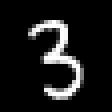

In [10]:
Gray.(transpose((dropdims((cpu(dataset[3][1][:,:,:,9]).+1.f0) ./ 2.f0; dims = 3))))

Funkcja pomocnicza, która pozwala nam rozszerzyć wymiarowość wektora:

In [11]:
expand_dims(x::AbstractVecOrMat, dims::Int=2) = reshape(x, (ntuple(i -> 1, dims)..., size(x)...))

expand_dims (generic function with 2 methods)

Pierwszą rzeczą, którą musimy odpowiednio zdefiniować jest sposób kodowania kolejnych kroków czasowych. Model, który wykorzystamy w procesie uczenia jest modelem statycznym - nie posiada on mechanizmu pozwalającego na kontrolę relacji pomiędzy kolejnymi napływającymi informacjami. Z tego powodu musimy mu podać, jako kolejną zmienną, krok którego dyfuzję ma policzyć.
Niestety, nie możemy zrobić tego po prostu podając indeks $t$ - taki model nie byłby w stanie efektywnie się uczyć. Dlatego musimy odpowiednio osadzić dane w przestrzeni. Wykorzystamy do tego wprowadzone wraz z mechanizmem atencji [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762) **kodowanie pozycyjne**. Dla każdego $t = {1,2,\dots,T}$ definiujemy osadzenie $\mathcal{E}(t)$ jako: 

$$
\begin{eqnarray}
\mathcal{E}(t, 2i) &=& \sin\Big(\frac{t}{n^{2i/d}}\Big)\\
\mathcal{E}(t, 2i+1) &=& \cos\Big(\frac{t}{n^{2i/d}}\Big)
\end{eqnarray}
$$

gdzie $\mathcal{E}(t, j)$ to odpowiednie pole macierzy $\mathcal{E}$, $d$ to wymiarowość osadzenia, $i = 1,2,\dots,d/2$ pozycja w wierszu, a $n$ ustalona z góry stała (najczęściej 10 000).

In [12]:
function PositionalEncoding(embed_dim)
    # Instantiate ω once
    ω = 10000.f0 .^ (collect(0:2:embed_dim-1) ./ embed_dim)
    # Return a function that always references the same ω
    PositionalEncoding(t) = Float32.(vcat(sin.(ω * t'), cos.(ω * t')))
end

PositionalEncoding (generic function with 1 method)

alternatywnie [(Tancik et al. 2020)](https://arxiv.org/abs/2006.10739):

In [13]:
function GaussianFourierProjection(embed_dim, scale)
    # Instantiate W once
    W = randn(Float32, embed_dim ÷ 2) .* scale
    # Return a function that always references the same W
    function GaussFourierProject(t)
        t_proj = t' .* W * Float32(2π)
        [sin.(t_proj); cos.(t_proj)]
    end
end

GaussianFourierProjection (generic function with 1 method)

Jako architekturę w procesie uczenia wykorzystamy **U-Net** [(Ronneberger et al., 2015)](https://arxiv.org/abs/1505.04597):
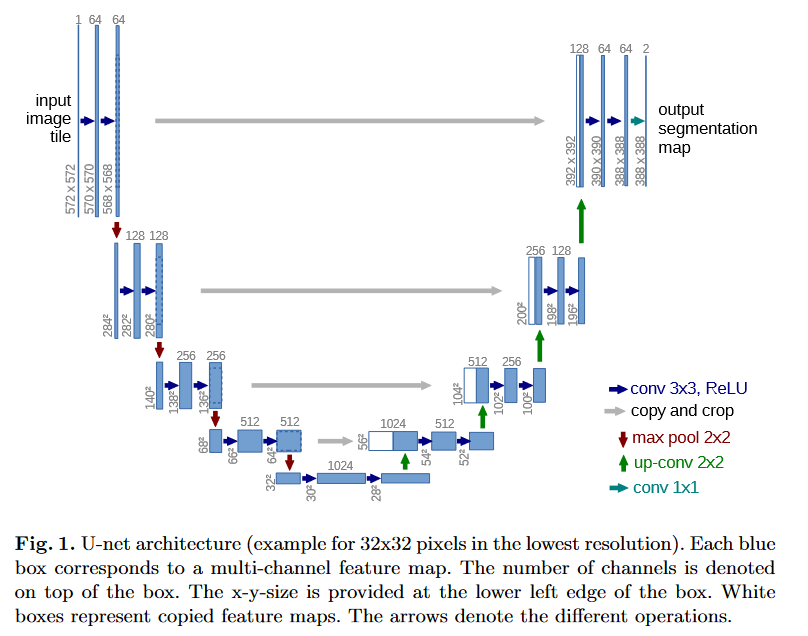
*źródło: [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)*

Jest to architektura, która powstała w celu przeprowadzenia efektywnej segmentacji obrazu - wykrywania jednorodnych (ze względu na pewną cechę) fragmentów zadanego obrazu. Ze względu na swoja konstrukcję, U-Net doskonale nadaje się do wykorzystania w modelowaniu za pomocą dyfuzji.

In [14]:
struct UNet
    #label embedding
    label_embed::Flux.Chain
    #time embedding
    time_embed::Flux.Chain
    #UNet Layers
    embed_layers::NamedTuple
    conv_layers::NamedTuple
    gnorm_layers::NamedTuple
end

In [15]:
function UNet(time_dim=256, label_dim = 1, scale=30.0f0)
    label_embed = Chain(Dense(10,28^2 * label_dim), x-> reshape(x, 28, 28, label_dim, size(x, 2)))
    time_embed = Chain(PositionalEncoding(time_dim), Dense(time_dim, time_dim, swish))
    embed_layers = (encode1 = Dense(time_dim, 32),
                    encode2 = Dense(time_dim, 64),
                    encode3 = Dense(time_dim, 128),
                    encode4 = Dense(time_dim, 256),
                    decode1 = Dense(time_dim, 128),
                    decode2 = Dense(time_dim, 64),
                    decode3 = Dense(time_dim, 32))
    conv_layers = (encode1 = Conv((3, 3), 1 + label_dim => 32, stride=1, bias=false),
                   encode2 = Conv((3, 3), 32 => 64, stride=2, bias=false),
                   encode3 = Conv((3, 3), 64 => 128, stride=2, bias=false),
                   encode4 = Conv((3, 3), 128 => 256, stride=2, bias=false),
                   decode1 = ConvTranspose((3, 3), 256 => 128, stride=2, bias=false),
                   decode2 = ConvTranspose((4, 4), 128 + 128 => 64, stride=2, bias=false),
                   decode3 = ConvTranspose((4, 4), 64 + 64 => 32, stride=2, bias=false),
                   decode4 =ConvTranspose((3, 3), 32 + 32 => 1, stride=1, bias=false))
    gnorm_layers = (encode1 = GroupNorm(32, 4, swish),
                    encode2 = GroupNorm(64, 32, swish),
                    encode3 =GroupNorm(128, 32, swish),
                    encode4 =GroupNorm(256, 32, swish),
                    decode1 = GroupNorm(128, 32, swish),
                    decode2 = GroupNorm(64, 32, swish),
                    decode3 = GroupNorm(32, 32, swish))
    return UNet(label_embed,time_embed, embed_layers, conv_layers, gnorm_layers)
end

@functor UNet

In [16]:
function (unet::UNet)(x, label, t)
    #Label embedding
    label = unet.label_embed(label)
    #Time embedding
    embed = unet.time_embed(t)
    #UNet encoder
    h0 = cat(x, label, dims = 3)
    
    h1 = unet.conv_layers.encode1(h0)
    h1 = unet.gnorm_layers.encode1(h1)
    h1 = h1 .+ expand_dims(unet.embed_layers.encode1(embed), 2)
    
    h2 = unet.conv_layers.encode2(h1)
    h2 = unet.gnorm_layers.encode2(h2)
    h2 = h2 .+ expand_dims(unet.embed_layers.encode2(embed), 2)
    
    h3 = unet.conv_layers.encode3(h2)
    h3 = unet.gnorm_layers.encode3(h3)
    h3 = h3 .+ expand_dims(unet.embed_layers.encode3(embed), 2)
    
    h4 = unet.conv_layers.encode4(h3)
    h4 = unet.gnorm_layers.encode4(h4)
    h4 = h4 .+ expand_dims(unet.embed_layers.encode4(embed), 2)
    
    #Decoder
    h = unet.conv_layers.decode1(h4)
    h = unet.gnorm_layers.decode1(h)
    h = h .+ expand_dims(unet.embed_layers.decode1(embed), 2)
    
    h = cat(h, h3; dims=3)
    h = unet.conv_layers.decode2(h)
    h = unet.gnorm_layers.decode2(h)
    h = h .+ expand_dims(unet.embed_layers.decode2(embed), 2)
    
    h = cat(h, h2; dims=3)
    h = unet.conv_layers.decode3(h)
    h = unet.gnorm_layers.decode3(h)
    h = h .+ expand_dims(unet.embed_layers.decode3(embed), 2)
    
    h = cat(h, h1; dims=3)
    h = unet.conv_layers.decode4(h)
end

In [17]:
model = UNet() |> device;

Wyprowadźmy teraz dwa ważne kroki - mechanizm generowania obserwacji i funkcję kosztu, którą wykorzystamy w procesie uczenia. Zacznijmy od tego, że ze względu na przyjęte założenie o gaussowskiej naturze dyfuzji jesteśmy w stanie wyznaczyć wartość $x_t$ w dowolnym kroku. Przyjmijmy, że $\alpha = 1 -\beta$ i $\bar{\alpha}  = \prod_{i=1}^t \alpha_i$, wtedy:

$$
\begin{aligned}
x_t &= \sqrt{\alpha_t}x_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1}  \\
&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t (1 - \alpha_{t-1})} \boldsymbol{\epsilon}_{t-2}  + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1}  \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
\end{aligned}
$$
gdzie $\boldsymbol{\epsilon}, \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

W rezultacie otrzymujemy prawdopodobieństwo przejścia z $x_0$ do $x_t$ równe:

$$q(x_t \vert x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t)\mathbf{I})$$

W postaci kodu:

In [37]:
function noise_images(x,t)
    α_hat = reshape(α⁻[t],1,1,size(x)[3:4]...) |> device
    ϵ = Flux.randn_like(x)
    sqrt.(α_hat) .* x + sqrt.(1 .- α_hat) .* ϵ, ϵ
end

noise_images (generic function with 1 method)

Za względu na to, że $q(x_t \vert x_{t-1})$ jest procesem gaussowskim jego odwrotność $q(x_{t-1} \vert x_t)$ także ma taką własność. Co więcej, jesteśmy w stanie wyznaczyć je jawnie gdy założymy, ze jest warunkowane na $x_0$: 

$q(x_{t-1} \vert x_t, x_0) = \mathcal{N}(x_{t-1},\tilde{\mu}(x_t,x_0), \tilde{\beta_t} \bf{I})$

Okazuje się, że parametry takiego rozkłau są nastepujące:
$$
\begin{aligned}
\tilde{\beta}_t 
&= \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t \\
\tilde{\mu}_t (x_t, x_0)
&= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} x_0\\
&= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t - \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t) \\
&= \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)
\end{aligned}
$$



Aby znaleźć dobrą parametryzację procesu odwrotnej dyfuzji  $p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \Sigma_\theta(x_t,t))$, musimy znaleźć $\mu_\theta$ które będzie w stanie efektywnie aproksymować $\tilde{\mu_t}$ dla każdego $t$. W takim wypadku składniku funkcji kosztu $L_{t-1}$ sprowadzą się do wyznaczenia błędu średniokwadratowego pomiędzy  $\tilde{\mu_t}$ a  $\mu_\theta$:

$$
\begin{aligned}
L_{t-1} 
&\approx \mathbb{E}_{q} \Big[\frac{1}{2 \| \Sigma_\theta(x_t, t) \|^2_2} \| \tilde{\mu}_t(x_t, x_0) - \mu_\theta(x_t, t) \|^2 \Big] \\
&= \mathbb{E}_{x_0, \boldsymbol{\epsilon}} \Big[\frac{1}{2 \| \Sigma_\theta \|^2_2} \| \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big) - \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(x_t, t) \Big) \|^2 \Big] \\
&= \mathbb{E}_{x_0, \boldsymbol{\epsilon}} \Big[\frac{ \beta_t^2 }{2 \alpha_t (1 - \bar{\alpha}_t) \| \Sigma_\theta \|^2_2} \|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(x_t, t)\|^2 \Big] \\
\end{aligned}
$$

Co więcej, okazuje się, że rozwiązanie da się jeszcze uprościć (co interesujące, poprawiając przy tym wynik modelu!). Po pierwsze, możliwe jest pominięcie wagi $\frac{ \beta_t^2 }{2 \alpha_t (1 - \bar{\alpha}_t) \| \Sigma_\theta \|^2_2}$ w procesie uczenia. Uproszczona forma funkcji $L_{t-1}$ przyjmuje postać:
$$
\begin{aligned}
L_{t-1}^\text{simple}
&= \mathbb{E}_{t, x_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(x_t, t)\|^2 \Big] \\
&= \mathbb{E}_{t, x_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)\|^2 \Big]
\end{aligned}
$$

Po drugie, dzięki reparametryzacji, nie musimy liczyć wartości oczekiwanej $L_t$ po wszystkich wartościach $t$, wystarczy wyznaczenie tej wartości dla losowo wybranej próbki danych - przy odpowiednio długim okresie uczenia wynik będzie taki sam. 

Zdefiniujmy funkcje pomocnicze pozwalające na samplowanie obrazów:

In [19]:
function sample(x, labels)
    @eval Flux.istraining() = false
    for t in T:-1:1
        predicted_noise = model(x, labels, t)
        alpha = α[t] |> device
        alpha_hat = α⁻[t] |> device
        beta = βs[t] |> device
        if t > 1
            noise = Flux.randn_like(x)
        else
            noise = Flux.zeros_like(x)
        end
        x = 1 ./ sqrt.(alpha) * (x - ((1 .- alpha) ./ (sqrt.(1 .- alpha_hat))) .* predicted_noise) .+ sqrt.(beta) .* noise
    end
    @eval Flux.istraining() = true
    x = (clamp.(x, -1.f0, 1.f0) .+ 1.f0) ./ 2.f0 |> cpu
    hcat([Gray.(transpose(reshape(x[:,:,:,i], 28, 28))) for i = 1:size(x)[4]]...)
end

sample (generic function with 1 method)

In [20]:
function sample_animate(x, labels, gif_name; forward = false, FPS = 10, gif_length = 5)
    frame_freq = T/(FPS*gif_length)
    frames = []
    @eval Flux.istraining() = false
    if forward
        for t in 1:1:T
            α_hat = α⁻[t]
            ϵ = Flux.randn_like(x)
            x = sqrt.(α_hat) .* x + sqrt.(1 .- α_hat) .* ϵ
            if mod(t,frame_freq) == 0
                xp = (clamp.(x, -1.f0, 1.f0) .+ 1.f0) ./ 2.f0 |> cpu
                p = plot(hcat([Gray.(transpose(reshape(xp[:,:,:,i], 28, 28))) for i = 1:size(x)[4]]...),
                    ticks = false, showaxis = false)
                push!(frames,p)
            end
        end 
    else
        for t in T:-1:1
            predicted_noise = model(x, labels, t)
            alpha = α[t] |> device
            alpha_hat = α⁻[t] |> device
            beta = βs[t] |> device
            if t > 1
                noise = Flux.randn_like(x)
            else
                noise = Flux.zeros_like(x)
            end
            x = 1 ./ sqrt.(alpha) * (x - ((1 .- alpha) ./ (sqrt.(1 .- alpha_hat))) .* predicted_noise) .+ sqrt.(beta) .* noise
            if mod(t,frame_freq) == 0
                xp = (clamp.(x, -1.f0, 1.f0) .+ 1.f0) ./ 2.f0 |> cpu
                p = plot(hcat([Gray.(transpose(reshape(xp[:,:,:,i], 28, 28))) for i = 1:size(x)[4]]...),
                    ticks = false, showaxis = false)
                push!(frames,p)
            end 
        end
    end
    @eval Flux.istraining() = true
    anim = @animate for frame in frames
        plot(frame)
    end
    anim
    gif(anim, gif_name, fps = FPS)
end

sample_animate (generic function with 1 method)

[ Info: Saved animation to C:\Users\barto\forward.gif


Plots.AnimatedGif("C:\\Users\\barto\\forward.gif")
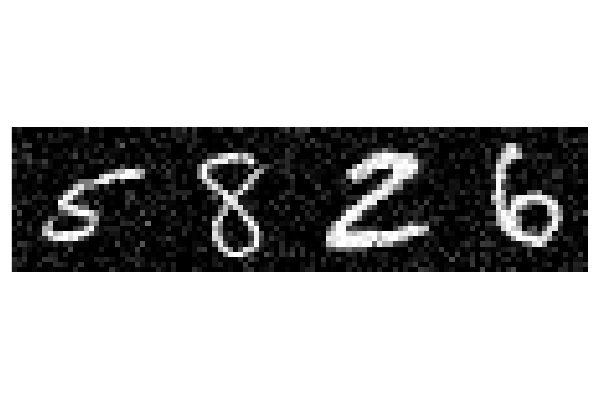

In [21]:
btch = rand(1:batch_size,4)
sample_animate(dataset[3][1][:,:,:,btch],
                    dataset[3][2][:, btch], "forward.gif", forward=true)

Optymalizator:

In [22]:
opt = Flux.Adam(0.001)  
opt_state = Flux.setup(opt, model);

Przejdźmy do procesu uczenia:

In [23]:
x0 = Flux.randn_like(dataset[3][1][:,:,:,rand(1:batch_size,4)]);
label = dataset[3][2][:, rand(1:batch_size,4)];

1×4 Matrix{Int64}:
 2  5  5  9

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Conv((3, 3), 2 => 32, bias=false)  # 576 parameters
│   summary(x) = "28×28×2×4 CuArray{Float64, 4, CUDA.Mem.DeviceBuffer}"
└ @ Flux C:\Users\barto\.julia\packages\Flux\Wz6D4\src\layers\stateless.jl:60


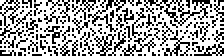

[ Info: Beginning training loop...
[ Info: Epoch 1
┌ Warning: Performing scalar indexing on task Task (runnable) @0x0000027f620e83f0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore C:\Users\barto\.julia\packages\GPUArraysCore\GMsgk\src\GPUArraysCore.jl:149
[ Info: Epoch: 1, loss = 0.11572975


1×4 Matrix{Int64}:
 2  5  5  9

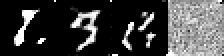

[ Info: Epoch 2
[ Info: Epoch: 2, loss = 0.052387603


1×4 Matrix{Int64}:
 2  5  5  9

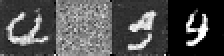

[ Info: Epoch 3
[ Info: Epoch: 3, loss = 0.044420157


1×4 Matrix{Int64}:
 2  5  5  9

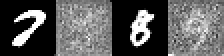

[ Info: Epoch 4
[ Info: Epoch: 4, loss = 0.04092066


1×4 Matrix{Int64}:
 2  5  5  9

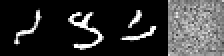

[ Info: Epoch 5
[ Info: Epoch: 5, loss = 0.03830178


1×4 Matrix{Int64}:
 2  5  5  9

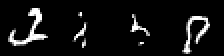

[ Info: Epoch 6
[ Info: Epoch: 6, loss = 0.036740825


1×4 Matrix{Int64}:
 2  5  5  9

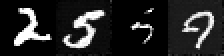

[ Info: Epoch 7
[ Info: Epoch: 7, loss = 0.03559447


1×4 Matrix{Int64}:
 2  5  5  9

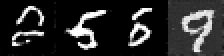

[ Info: Epoch 8
[ Info: Epoch: 8, loss = 0.03476324


1×4 Matrix{Int64}:
 2  5  5  9

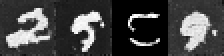

[ Info: Epoch 9
[ Info: Epoch: 9, loss = 0.033249952


1×4 Matrix{Int64}:
 2  5  5  9

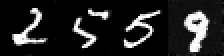

[ Info: Epoch 10
[ Info: Epoch: 10, loss = 0.03352698


1×4 Matrix{Int64}:
 2  5  5  9

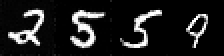

[ Info: Epoch 11
[ Info: Epoch: 11, loss = 0.03231121


1×4 Matrix{Int64}:
 2  5  5  9

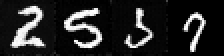

[ Info: Epoch 12
[ Info: Epoch: 12, loss = 0.032029875


1×4 Matrix{Int64}:
 2  5  5  9

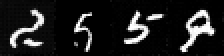

[ Info: Epoch 13
[ Info: Epoch: 13, loss = 0.03154618


1×4 Matrix{Int64}:
 2  5  5  9

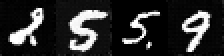

[ Info: Epoch 14
[ Info: Epoch: 14, loss = 0.031255297


1×4 Matrix{Int64}:
 2  5  5  9

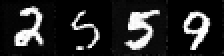

[ Info: Epoch 15
[ Info: Epoch: 15, loss = 0.030718807


1×4 Matrix{Int64}:
 2  5  5  9

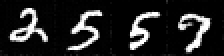

[ Info: Epoch 16
[ Info: Epoch: 16, loss = 0.030049989


1×4 Matrix{Int64}:
 2  5  5  9

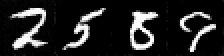

[ Info: Epoch 17
[ Info: Epoch: 17, loss = 0.03015794


1×4 Matrix{Int64}:
 2  5  5  9

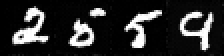

[ Info: Epoch 18
[ Info: Epoch: 18, loss = 0.029296031


1×4 Matrix{Int64}:
 2  5  5  9

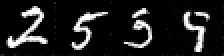

[ Info: Epoch 19
[ Info: Epoch: 19, loss = 0.02938176


1×4 Matrix{Int64}:
 2  5  5  9

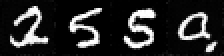

[ Info: Epoch 20
[ Info: Epoch: 20, loss = 0.028699446


1×4 Matrix{Int64}:
 2  5  5  9

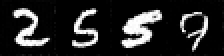

[ Info: Epoch 21
[ Info: Epoch: 21, loss = 0.029172596


1×4 Matrix{Int64}:
 2  5  5  9

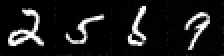

[ Info: Epoch 22
[ Info: Epoch: 22, loss = 0.02862092


1×4 Matrix{Int64}:
 2  5  5  9

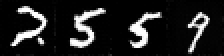

[ Info: Epoch 23
[ Info: Epoch: 23, loss = 0.02867691


1×4 Matrix{Int64}:
 2  5  5  9

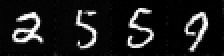

[ Info: Epoch 24
[ Info: Epoch: 24, loss = 0.028444458


1×4 Matrix{Int64}:
 2  5  5  9

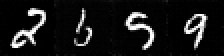

[ Info: Epoch 25
[ Info: Epoch: 25, loss = 0.028586766


1×4 Matrix{Int64}:
 2  5  5  9

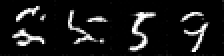

[ Info: Epoch 26
[ Info: Epoch: 26, loss = 0.027710922


1×4 Matrix{Int64}:
 2  5  5  9

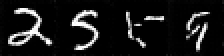

[ Info: Epoch 27
[ Info: Epoch: 27, loss = 0.028432634


1×4 Matrix{Int64}:
 2  5  5  9

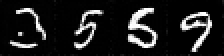

[ Info: Epoch 28
[ Info: Epoch: 28, loss = 0.027736096


1×4 Matrix{Int64}:
 2  5  5  9

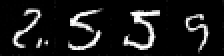

[ Info: Epoch 29
[ Info: Epoch: 29, loss = 0.02798807


1×4 Matrix{Int64}:
 2  5  5  9

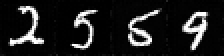

[ Info: Epoch 30
[ Info: Epoch: 30, loss = 0.027882291


1×4 Matrix{Int64}:
 2  5  5  9

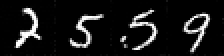

[ Info: Epoch 31
[ Info: Epoch: 31, loss = 0.027953


1×4 Matrix{Int64}:
 2  5  5  9

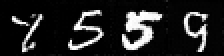

[ Info: Epoch 32
[ Info: Epoch: 32, loss = 0.027373204


1×4 Matrix{Int64}:
 2  5  5  9

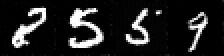

[ Info: Epoch 33
[ Info: Epoch: 33, loss = 0.027661745


1×4 Matrix{Int64}:
 2  5  5  9

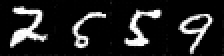

[ Info: Epoch 34
[ Info: Epoch: 34, loss = 0.027303763


1×4 Matrix{Int64}:
 2  5  5  9

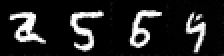

[ Info: Epoch 35
[ Info: Epoch: 35, loss = 0.02701353


1×4 Matrix{Int64}:
 2  5  5  9

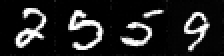

[ Info: Epoch 36
[ Info: Epoch: 36, loss = 0.026982918


1×4 Matrix{Int64}:
 2  5  5  9

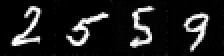

[ Info: Epoch 37
[ Info: Epoch: 37, loss = 0.027021343


1×4 Matrix{Int64}:
 2  5  5  9

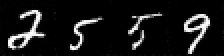

[ Info: Epoch 38
[ Info: Epoch: 38, loss = 0.026699571


1×4 Matrix{Int64}:
 2  5  5  9

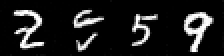

[ Info: Epoch 39
[ Info: Epoch: 39, loss = 0.026944963


1×4 Matrix{Int64}:
 2  5  5  9

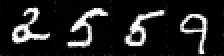

[ Info: Epoch 40
[ Info: Epoch: 40, loss = 0.026992595


1×4 Matrix{Int64}:
 2  5  5  9

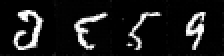

[ Info: Epoch 41
[ Info: Epoch: 41, loss = 0.02678017


1×4 Matrix{Int64}:
 2  5  5  9

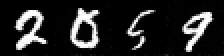

[ Info: Epoch 42
[ Info: Epoch: 42, loss = 0.026380748


1×4 Matrix{Int64}:
 2  5  5  9

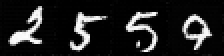

[ Info: Epoch 43
[ Info: Epoch: 43, loss = 0.026831046


1×4 Matrix{Int64}:
 2  5  5  9

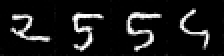

[ Info: Epoch 44
[ Info: Epoch: 44, loss = 0.026173176


1×4 Matrix{Int64}:
 2  5  5  9

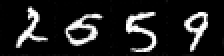

[ Info: Epoch 45
[ Info: Epoch: 45, loss = 0.026399221


1×4 Matrix{Int64}:
 2  5  5  9

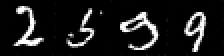

[ Info: Epoch 46
[ Info: Epoch: 46, loss = 0.026707008


1×4 Matrix{Int64}:
 2  5  5  9

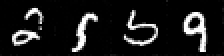

[ Info: Epoch 47
[ Info: Epoch: 47, loss = 0.026430875


1×4 Matrix{Int64}:
 2  5  5  9

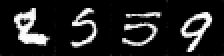

[ Info: Epoch 48
[ Info: Epoch: 48, loss = 0.026463825


1×4 Matrix{Int64}:
 2  5  5  9

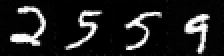

[ Info: Epoch 49
[ Info: Epoch: 49, loss = 0.02591673


1×4 Matrix{Int64}:
 2  5  5  9

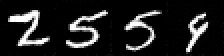

[ Info: Epoch 50
[ Info: Epoch: 50, loss = 0.026334617


1×4 Matrix{Int64}:
 2  5  5  9

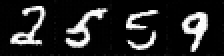

[ Info: Done! Saving model out to diffusionMNIST.bson


In [24]:
display(reduce(vcat, reduce.(hcat, partition(Flux.onecold(cpu(label)), 4))) .- 1)
display(sample(x0,label))
@info("Beginning training loop...")
for epoch = 1:50
    mloss = 0.0
    @info "Epoch $epoch"
    for (x, labels) in dataset
        ps = params(model)
        bloss, back = Zygote.pullback(ps) do
            t = rand(1:T, size(x)[end]) |> device
            xₜ, noise = noise_images(x, t)
            predicted_noise = model(xₜ, labels, t)
            Flux.mse(noise, predicted_noise)
        end
        grads = back(1f0)
        Flux.Optimise.update!(opt, ps, grads)
        mloss += bloss 
    end
    mloss /= length(dataset)
    @info("Epoch: $epoch, loss = $mloss")
    display(reduce(vcat, reduce.(hcat, partition(Flux.onecold(cpu(label)), 4))) .- 1)
    display(sample(x0,label))
end
@info("Done! Saving model out to diffusionMNIST.bson")
jldsave("diffusionMNIST.jld2"; UNet = cpu(Flux.state(model)))

Wczytajmy model i go przetestujmy:

In [ ]:
model = UNet() |> device;
ps = JLD2.load("diffusionMNIST.jld2", "UNet")
Flux.loadmodel!(model, device(ps));

1×4 Matrix{Int64}:
 2  4  0  3

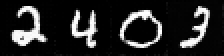

In [27]:
x0 = Flux.randn_like(dataset[3][1][:,:,:,rand(1:batch_size,4)]);
label = dataset[3][2][:, rand(1:batch_size,4)];
display(reduce(vcat, reduce.(hcat, partition(Flux.onecold(cpu(label)), 4))) .- 1)
display(sample(x0,label))

[ Info: Saved animation to C:\Users\barto\after.gif


Plots.AnimatedGif("C:\\Users\\barto\\after.gif")
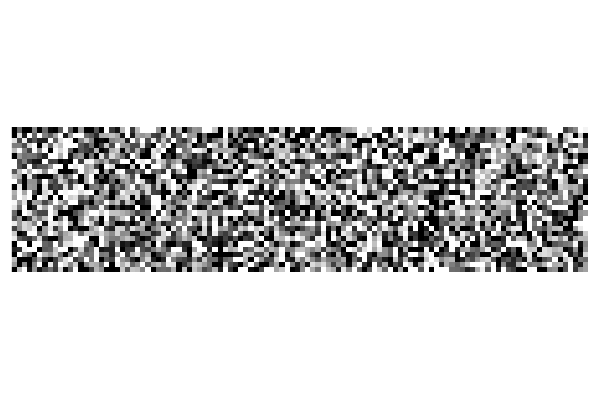

In [26]:
sample_animate(x0,label, "after.gif")